In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/CoLeaf DATASET'
print(os.listdir(train_dir))

['calcium-Ca', 'magnesium-Mg', 'healthy', 'nitrogen-N', 'iron-Fe', 'manganese-Mn', 'more-deficiencies', 'phosphorus-P', 'potasium-K', 'boron-B']


In [2]:
# Define dataset parameters
batch_size = 32
img_height = 224
img_width = 224

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 712 files belonging to 10 classes.
Using 570 files for training.
Found 712 files belonging to 10 classes.
Using 142 files for validation.
Class names: ['boron-B', 'calcium-Ca', 'healthy', 'iron-Fe', 'magnesium-Mg', 'manganese-Mn', 'more-deficiencies', 'nitrogen-N', 'phosphorus-P', 'potasium-K']


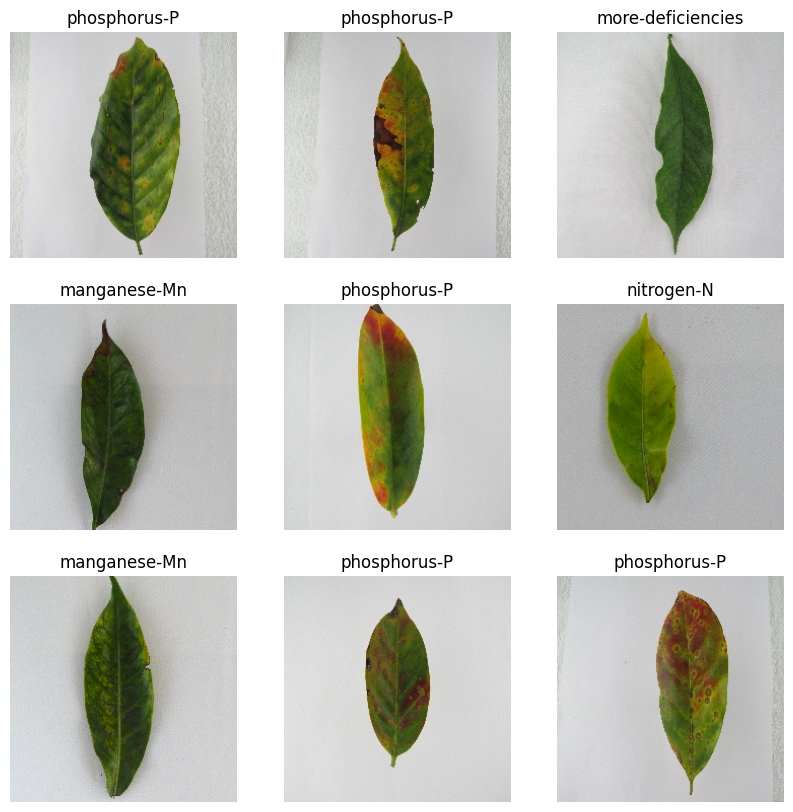

In [3]:
# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

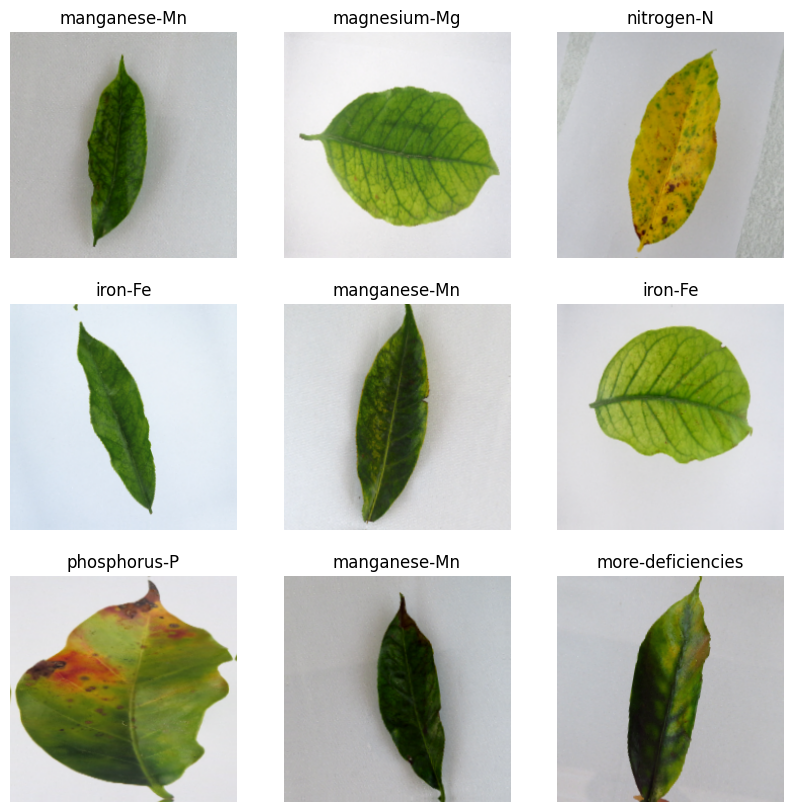

In [4]:
# Define the data augmentation layers with refined parameters
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomZoom(0.05),
    RandomContrast(0.1),
    RandomBrightness(0.1),
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Visualize some augmented images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Define the normalization layer
normalization_layer = Rescaling(1./255)

# Apply normalization to the augmented training dataset
normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to the validation dataset
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
# Preparing the Dataset for Training
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, batch, and prefetch the training dataset
train_ds = normalized_train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Cache, batch, and prefetch the validation dataset
val_ds = normalized_val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)


# Defining the Model Architectures

# 1. Custom CNN Model
def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# 2. ResNet50 Model
def create_resnet50(input_shape, num_classes):
    base_model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights=None)  # Set weights=None
    model = tf.keras.Sequential([
        base_model,
        Dense(num_classes, activation='softmax')
    ])
    return model

In [6]:
# Compiling the models

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

# Custom CNN Model
custom_cnn_model = create_custom_cnn(input_shape, num_classes)
custom_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ResNet50 Model
resnet50_model = create_resnet50(input_shape, num_classes)
resnet50_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Train the Custom CNN Model
history_custom_cnn = custom_cnn_model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20  # Adjust the number of epochs as needed
)

# Evaluate the Custom CNN Model
loss, accuracy = custom_cnn_model.evaluate(normalized_val_ds)
print(f"Custom CNN Model - Loss: {loss}, Accuracy: {accuracy}")

# Train the ResNet50 Model
history_resnet50 = resnet50_model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=20  # Adjust the number of epochs as needed
)

# Evaluate the ResNet50 Model
loss, accuracy = resnet50_model.evaluate(normalized_val_ds)
print(f"ResNet50 Model - Loss: {loss}, Accuracy: {accuracy}")


Epoch 1/20
18/18 [==============================] - 182s 9s/step - loss: 2.4887 - accuracy: 0.2807 - val_loss: 1.6967 - val_accuracy: 0.3099
Epoch 2/20
18/18 [==============================] - 51s 2s/step - loss: 1.6299 - accuracy: 0.3684 - val_loss: 1.4998 - val_accuracy: 0.3803
Epoch 3/20
18/18 [==============================] - 49s 2s/step - loss: 1.4284 - accuracy: 0.4684 - val_loss: 1.4481 - val_accuracy: 0.5211
Epoch 4/20
18/18 [==============================] - 50s 2s/step - loss: 1.3439 - accuracy: 0.4807 - val_loss: 1.3622 - val_accuracy: 0.5423
Epoch 5/20
18/18 [==============================] - 50s 2s/step - loss: 1.2777 - accuracy: 0.5228 - val_loss: 1.3157 - val_accuracy: 0.5493
Epoch 6/20
18/18 [==============================] - 51s 2s/step - loss: 1.2492 - accuracy: 0.5421 - val_loss: 1.3119 - val_accuracy: 0.5070
Epoch 7/20
18/18 [==============================] - 52s 2s/step - loss: 1.2122 - accuracy: 0.5263 - val_loss: 1.2455 - val_accuracy: 0.5775
Epoch 8/20
18/18 [=

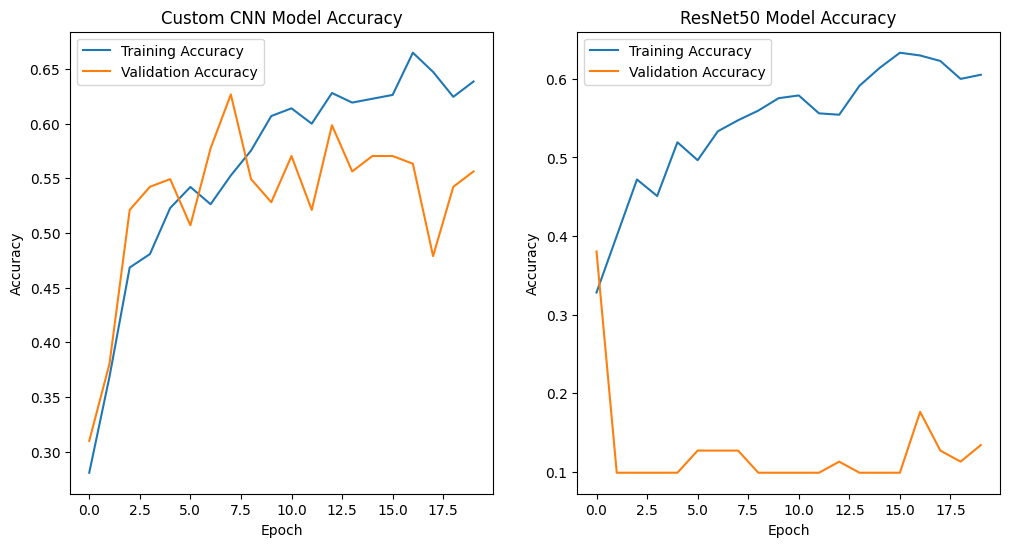

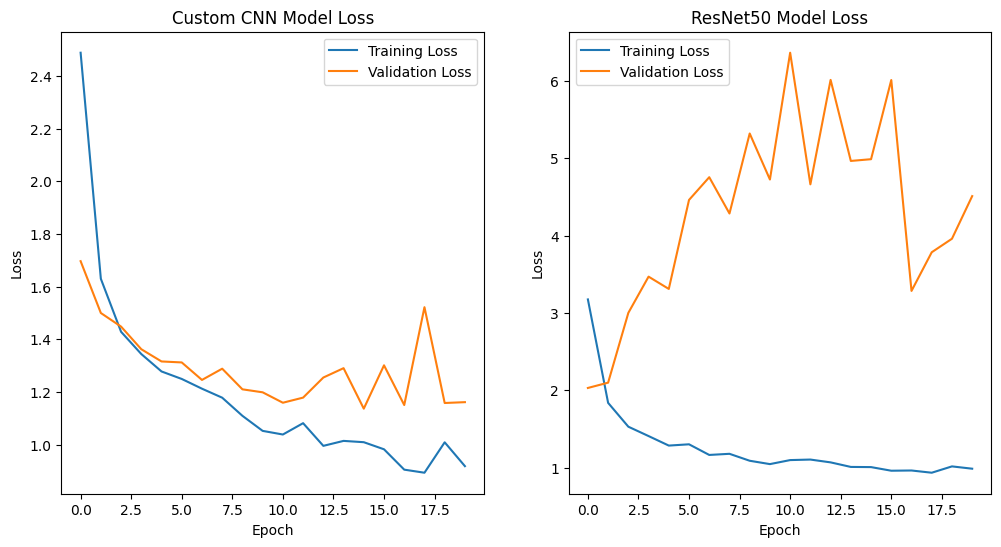

In [8]:

# Plot training and validation accuracy for both models
plt.figure(figsize=(12, 6))

# Custom CNN Model
plt.subplot(1, 2, 1)
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# ResNet50 Model
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot training and validation loss for both models
plt.figure(figsize=(12, 6))

# Custom CNN Model
plt.subplot(1, 2, 1)
plt.plot(history_custom_cnn.history['loss'], label='Training Loss')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ResNet50 Model
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()